In [1]:
using Pkg
#Pkg.activate()

#import Pkg
#Pkg.add(path="/home/harsh/Work/code/KadanoffBaym.jl")
#include("/home/harsh/Work/code/KadanoffBaym.jl")
#import KandaoffBaym
using KadanoffBaym
#reload("KadanoffBaym.jl")

using LinearAlgebra
#Pkg.update(LinearAlgebra)

#Pkg.add("BlockArrays")
using BlockArrays

#Pkg.add("ChainRulesCore")
using ChainRulesCore

using Distributions
#Pkg.add("Distributions")

#Pkg.add("PyPlot")
using PyPlot

using Catalyst

using DifferentialEquations
#using Plots

#import Pkg;
#Pkg.add("IterTools")
using IterTools

#Pkg.build("PyCall")

In [2]:
"""
    Response

Defined as 
`` G(t,t') = 0 if t' > t ``
"""
struct Response <: KadanoffBaym.AbstractSymmetry end

@inline KadanoffBaym.symmetry(::Type{Response}) = zero


In [3]:
#Parameters simulation
tmax = 2.
atol = 1e-5
rtol = 1e-3

0.001

## Define the reaction system and the defaults or initialization using Catalyst

In [4]:
rs_aaa = @reaction_network AAA begin
    @species A(t)= 4. /3
    @parameters k1A = 1. k2A = 1. k3 = 1. 
  (k3), A+A --> A
  (k2A,k1A), A <--> 0 
end

Model AAA
States (1):
  A(t) [defaults to 1.33333]
Parameters (3):
  k1A [defaults to 1.0]
  k2A [defaults to 1.0]
  k3 [defaults to 1.0]

## Morph the reaction structure from Catalyst to one more useful for us:

In [5]:
Base.@kwdef struct Reaction_structure{T1,T2,T3,T4}
    
    num_species::T1 = 0
    num_interactions::T1 = 0
    num_reactions::T1 = 2*num_species + num_interactions
    
    rate_creation::T2    = zeros(0)
    rate_destruction::T2 = zeros(0)
    rate_interaction::T4 = zeros(0) #Should this data type be T3?
    
    stochiometry_prod::T3  = zeros(0)
    stochiometry_react::T3 = zeros(0)
    
    initial_values::T4 = zeros(0)
    
end

function Reaction_structure(reaction_system::ReactionSystem,external_initialization=false)
    
    """
    TODO: Add support for external initialization
    """
    
    num_int        = 0
    initial_values = zeros(numspecies(reaction_system))
    k1             = zeros(numspecies(reaction_system))
    k2             = zeros(numspecies(reaction_system))
    k3             = zeros(0)
    s_i            = zeros(Int64,(numspecies(reaction_system),0))
    r_i            = zeros(Int64,(numspecies(reaction_system),0))
    temp_index     = 1

    for i in reactions(reaction_system)
        if length(dependents(i,reaction_system)) == 1 && length(i.products) == 0 
            #The destruction reaction
            sp     = speciesmap(reaction_system)[i.substrates[1]]
            k2[sp] = reaction_system.defaults[i.rate]

        elseif length(dependents(i,reaction_system)) == 0 
            #The spontaneous creation reaction
            sp     = speciesmap(reaction_system)[i.products[1]]
            k1[sp] = reaction_system.defaults[i.rate]

        else 
            #The interaction reactions rates
            append!(k3,reaction_system.defaults[i.rate])

            #For stochiometry
            s_i = cat(s_i,prodstoichmat(reaction_system)[:,temp_index],dims=2)
            r_i = cat(r_i,substoichmat(reaction_system)[:,temp_index],dims=2)
            num_int += 1
        end
        temp_index += 1
    end

    #Store the initial values
    for i in species(reaction_system)
        sp = speciesmap(reaction_system)[i]
        initial_values[sp] = reaction_system.defaults[i]

    end
    
    return Reaction_structure(num_species = numspecies(reaction_system),
                                            num_interactions  = num_int,
                                            rate_creation     = k1,
                                            rate_destruction  = k2,
                                            rate_interaction  = k3,
                                            stochiometry_prod = s_i,
                                            stochiometry_react= r_i,
                                            initial_values    = initial_values)
end

Reaction_structure

In [6]:
structure = Reaction_structure(rs_aaa)

Reaction_structure{Int64, Vector{Float64}, Matrix{Int64}, Vector{Float64}}(1, 1, 3, [1.0], [1.0], [1.0], [1;;], [2;;], [1.3333333333333333])

In [13]:
Base.@kwdef struct Reaction_variables
    
    R = 0 
    μ = 0
    C = 0
    Σ_R = 0
    Σ_μ = 0
    Σ_B = 0
    Σ_R_temp = 0
    Σ_μ_temp = 0
    
end

function Reaction_variables(reaction_system::Reaction_structure,response_type="cross")
    
    if response_type == "single"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Reaction_variables( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response),
            Σ_μ = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response),
            Σ_R_temp = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint),
            Σ_μ_temp = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint))
        
    elseif response_type == "cross"
        
        R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response)
        R[:,:,1,1] = ones(reaction_system.num_species,reaction_system.num_species)
        μ = GreenFunction(zeros(Float64,reaction_system.num_species,1), OnePoint)
        μ[:,1] = reaction_system.initial_values
        
        return Reaction_variables( 
            R = R,
            μ = μ,
            Σ_R = GreenFunction(zeros(Float64,reaction_system.num_species,reaction_system.num_species,1,1), Response),
            Σ_μ = GreenFunction(zeros(Float64,reaction_system.num_species,1,1), Response))
    end
    #Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) 
    #Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

end

Reaction_variables

In [14]:
variables = Reaction_variables(structure,"single");

## Solve using the KB package:

In [74]:
function solve_dynamics(structure,variables,atol,rtol,tmax,tstart=0.)
    
    function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy correction to the mean
        """

        retval = zero(μ[t1])

        for k in 1:tmax
            retval +=  Σ[t1,k].*hs[k]
        end

        return retval
    end

    function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy corrections to the response
        """

        retval = zero(R[t1,t2])

        for k in t2:t1
            retval += Σ[t1,k].*R[k,t2]*hs[k] 
        end

        return retval
    end
    
    # Right-hand side for the "vertical" evolution
    function fv!(structure, variables, out, times, h1, h2, t, t′)

        retval  = zero(variables.R[t,t′])
        corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] += -structure.rate_destruction[j].*variables.R[j,t,t′]
        end

        out[1]  = retval .+ corr

    end

    #diagonal evolution
    function fd!(structure, variables, out, times, h1, h2, t, t′)
        out[1] = zero(out[1])
    end

    # one-time equation for condensate amplitude
    function f1!(structure, variables, out, times, h1, t)

        retval  = zero(variables.μ[t])
        corr    = integrate1(h1, t, variables.Σ_μ, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] += structure.rate_creation[j] .- structure.rate_destruction[j].*variables.μ[j,t]
        end
        
        out[1]  = retval .+ corr

    end
    
    # Callback function for the self-energies
    function self_energy_mak!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end

        for i in 1:structure.num_species
            temp0    = zeros(Int,structure.num_species)
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            variables.Σ_R[i,t,t′] = 0.
            variables.Σ_μ[i,t,t′] = 0.
            
            variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]

        end
    end
    
    function self_energy_alpha2!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        temp0    = zeros(Int,structure.num_species)
        
        for i in 1:structure.num_species
            
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            variables.Σ_R[i,t,t′] = 0.
            variables.Σ_μ[i,t,t′] = 0.
            variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
            
            for n ∈ n_listNEW
                if n ∉ [temp0,temp1]
                    
                    variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t)*
                    c_mnFULL(structure,variables,n,temp1,t′)*prod(factorial.(n).*variables.R[t,t′].^n)
                    
                end
                
                if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                    
                    variables.Σ_μ[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t)*
                    c_mnFULL(structure,variables,n,temp0,t′)*prod(factorial.(n).*variables.R[t,t′].^n)

                end
            end
        end
    end
    
    function self_energy_SBR!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        temp0  = zeros(Int,structure.num_species)
        id     = one(variables.R[1,1:t,1:t])
        L      = diagm(-1=>ones(t-1))
        
        for i in 1:structure.num_species
            
            temp1    = zeros(Int,structure.num_species)
            temp1[i] = 1
            
            variables.Σ_R[i,t,t′] = 0.
            variables.Σ_μ[i,t,t′] = 0.
            variables.Σ_R[i,t,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
            variables.Σ_μ[i,t,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]
            
        end
        
        for n in n_listNEW
            
            if c_mnFULL_test(structure,variables,n,n) != 0 && c_mnFULL_test(structure,variables,n,temp0) != 0
                
                #This loop is executed iff cnn != 0 and Mv != 0
                
                cNN = collect(c_mnFULL(structure,variables,n,n,tt) for tt in 1:t)
                Mv  = diagm([c_mnFULL(structure,variables,n,temp0,tt) for tt in 1:t])
                #Mv = collect(c_mnFULL(structure,variables,n,temp0,tt) for tt in 1:t)

                Γ   = collect(prod(factorial.(n) .* variables.R[:,tt,ttt] .^n) for tt in 1:t, ttt in 1:t)

                #The following creates the \Chi matrix (with the shift), but also multiples the columns by the time step size
                χ   = circshift(collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t),(0,-1))

                #Use the LAPAC functions to invert the triangular matrix here!
                Ξ   = tril(id - χ)
                LAPACK.trtri!('L','U',Ξ)
                Ξ  *= Γ
                ΞMv = Ξ*Mv 

                for i in 1:structure.num_species

                    temp1    = zeros(Int,structure.num_species)
                    temp1[i] = 1
                    Mf       = diagm([c_mnFULL(structure,variables,n,temp1,tt) for tt in 1:t])
                    ΞMf      = Ξ*Mf

                    if n ∉ [temp0,temp1]
                        variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*ΞMf[t,t′]
                        #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mf)[t,t′]
                    end

                    if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                        variables.Σ_μ[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*ΞMv[t,t′]
                        #variables.Σ_μ[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mv)[t,t′]
                        #variables.Σ_R[i,t,t′] += c_mnFULL(structure,variables,temp1,n,t).*(Ξ*Mf)[t,t′]
                    end
                end
            end
        end
        
        print(t," ",t′, " ", variables.Σ_R[1,t,t′],'\n')
    end
    
    
    
    function self_energy_SBR_old_ABC!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end

        id = one(variables.Σ_R[1,1:t,1:t])

        shifted1 = circshift(variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t],(-1,0))
        #shifted2 = circshift(resp_gf[2,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))

        for k in 1:t
            shifted1[k,1:t] .*= h1
            #shifted2[k,1:t] .*= h1
        end

        variables.Σ_R[1,t,t′] = ((variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t])*inv(tril(id + structure.rate_interaction[1].*shifted1[:,:])))[t,t′]
        variables.Σ_R[2,t,t′] = variables.Σ_R[1,t,t′]
        
        variables.Σ_μ[t,t′] = variables.Σ_R[t,t′]
        
    end
    
    @time sol = kbsolve!(
    (x...) -> fv!(structure, variables, x...),
    (x...) -> fd!(structure, variables, x...),
    [variables.R],
    (tstart, tmax);
    callback = (x...) -> self_energy_SBR!(structure, variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [variables.μ],
    f1! = (x...) -> f1!(structure, variables, x...))
    
    return sol
end

solve_dynamics (generic function with 2 methods)

In [88]:
    function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy correction to the mean
        """

        retval = zero(μ[t1])

        for k in 1:tmax
            retval +=  Σ[t1,k]*hs[k]
        end
        
        return retval
    end

    function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy corrections to the response
        """

        retval = zero(R[t1,t2])

        for k in t2:t1
            #retval += Σ[t1,k].*R[k,t2].*hs[k] #Need to add a shift here? --IMP (PAY ATTENTION!)
            retval += Σ[t1,k].*R[k,t2].*hs[k] #This has been shifted! PAY ATTENTION!
        end

        return retval
    end
    
    # Right-hand side for the "vertical" evolution
    function fv!(structure, variables, out, times, h1, h2, t, t′)
    
        #retval  = zero(variables.R[t,t′])
        #corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        #for j in 1:structure.num_species
        #    retval[j] += -structure.rate_destruction[j].*variables.R[j,t,t′]
        #end

        #out[1]  = retval .+ corr

    #end
        
        #if t == 1
            #self_energy_mak!(structure, variables, times, h1, h1 , t, t) #-- not needed called while calling f1
            #corr = deepcopy(variables.Σ_R[t,t])
        #else
            corr = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        #end
        
        retval  = zero(variables.R[t,t′])
        #corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] = -structure.rate_destruction[j].*variables.R[j,t,t′]
        end

        out[1]  = retval .+ corr

    end
    
     #diagonal evolution    
    function fd!(structure, variables, out, times, h1, h2, t, t′)    
        out[1] = zero(out[1])
    end


    function f1!(structure, variables, out, times, h1, t)
        # one-time equation for condensate amplitude
        
        #if t == 1
            
        #    self_energy_mak!(structure, variables, times, h1, h1 , t, t)
        #    corr = deepcopy(variables.Σ_μ[t,t])

        #else
            corr = integrate1(h1, t, variables.Σ_μ, variables.μ)
        #end

        retval   = zero(variables.μ[t])
        
        for j in 1:structure.num_species
            retval[j] = structure.rate_creation[j] .- structure.rate_destruction[j].*variables.μ[j,t]
        end
        
        out[1]  .= retval .+ corr
        
    end

f1! (generic function with 1 method)

In [89]:
#cmn defined with t-1 and the first c0n or c01 defined with t+1

function solve_dynamics(structure,variables,atol,rtol,tmax,tstart=0.)
    
    function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy correction to the mean
        """

        retval = zero(μ[t1])

        for k in 1:tmax
            retval +=  Σ[t1,k]*hs[k]
        end
        
        return retval
    end

    function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
        """
        To integrate the self-energy corrections to the response
        """

        retval = zero(R[t1,t2])

        for k in t2:t1
            #retval += Σ[t1,k].*R[k,t2].*hs[k] #Need to add a shift here? --IMP (PAY ATTENTION!)
            retval += Σ[t1,k].*R[k,t2]*hs[k] #This has been shifted! PAY ATTENTION!
        end

        return retval
    end
    
    # Right-hand side for the "vertical" evolution
    function fv!(structure, variables, out, times, h1, h2, t, t′)
        
        #if t == 1
            #self_energy_mak!(structure, variables, times, h1, h1 , t, t) #-- not needed called while calling f1
            #corr = deepcopy(variables.Σ_R[t,t])
        #else
            corr = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        #end
        
        retval  = zero(variables.R[t,t′])
        #corr    = integrate2(h1, t, t′, variables.Σ_R, variables.R, variables.μ)
        
        for j in 1:structure.num_species
            retval[j] = -structure.rate_destruction[j].*variables.R[j,t,t′]
        end

        out[1]  = retval .+ corr

    end
    
     #diagonal evolution    
    function fd!(structure, variables, out, times, h1, h2, t, t′)    
        out[1] = zero(out[1])
    end


    function f1!(structure, variables, out, times, h1, t)
        # one-time equation for condensate amplitude
        
        #if t == 1
            
        #    self_energy_mak!(structure, variables, times, h1, h1 , t, t)
        #    corr = deepcopy(variables.Σ_μ[t,t])

        #else
        corr = integrate1(h1, t, variables.Σ_μ, variables.μ)
        #end

        retval   = zero(variables.μ[t])
        
        for j in 1:structure.num_species
            retval[j] = structure.rate_creation[j] .- structure.rate_destruction[j].*variables.μ[j,t]
        end
        
        out[1]  = retval .+ corr
        
    end
    
    

    function self_energy_mak!(structure, variables, times, h1, h2 , t, t′)
        # Callback function for the self-energies
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            temp0  = zeros(Int,structure.num_species)
            
            for i in 1:structure.num_species
                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                if t == 1
                    #No deivision by step size at initial time because its zero
                    variables.Σ_R[i,t,t] = c_mnFULL(structure,variables,temp1,temp1,t+1)
                    variables.Σ_μ[i,t,t] = c_mnFULL(structure,variables,temp1,temp0,t+1)
                else            
                    variables.Σ_R[i,t,t] = c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                    variables.Σ_μ[i,t,t] = c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]
                end

            end
        end

    end
    
    function self_energy_alpha2!(structure, variables, times, h1, h2 , t, t′)

        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            
            #Temporary variables declared to hold the field values!
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) 
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
        
            temp0    = zeros(Int,structure.num_species)
        
            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]

                for n ∈ n_listNEW
                    if n ∉ [temp0,temp1]
                        
                        Σ_R_temp[i,1:t] += c_mnFULL(structure,variables,temp1,n,t+1).*collect(
                        c_mnFULL(structure,variables,n,temp1,t′)*prod(factorial.(n).*variables.R[t,t′].^n) for t′ in 1:t)

                    end

                    if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)
                        
                        Σ_μ_temp[i,1:t] += c_mnFULL(structure,variables,temp1,n,t+1).*collect(
                        c_mnFULL(structure,variables,n,temp0,t′)*prod(factorial.(n).*variables.R[t,t′].^n) for t′ in 1:t)

                    end
                end
            end
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 
            
        end
    end
    
    function self_energy_SBR!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
            m = size(variables.μ, 2) 
            resize!(variables.Σ_R_temp,m)
            resize!(variables.Σ_μ_temp,m)
        end
        
        variables.Σ_μ[:,t,t′] .= 0.
        variables.Σ_R[:,t,t′] .= 0.
                
        if t′ == 1
        
            temp0  = zeros(Int,structure.num_species)
            id     = diagm(ones(t))
            L      = diagm(-1=>ones(t-1))
            
            #variables.Σ_μ[:,t,1:t] .= 0.
            #variables.Σ_R[:,t,1:t] .= 0.
                    
            variables.Σ_R_temp[:,:] .= 0.
            variables.Σ_μ_temp[:,:] .= 0.
            
            #Temporary variables declared to hold the field values!
            #variables.Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) 
            #variables.Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1

                variables.Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t)./h1[t]
                variables.Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t)./h1[t]

            end

            for n in n_listNEW
                
                #This loop is executed iff cnn != 0 #and cN0 != 0
                if c_mnFULL_test(structure,variables,n,n) != 0 && c_mnFULL_test(structure,variables,n,temp0) != 0

                    cNN = collect(c_mnFULL(structure,variables,n,n,tt) for tt in 1:t)
                    Γ   = collect(prod(factorial.(n) .* variables.R[:,tt,ttt] .^n) for tt in 1:t, ttt in 1:t)                
                    cN0 = collect(c_mnFULL(structure,variables,n,temp0,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)

                    #The following creates the \Chi matrix (with the shift), but also multiples the columns by the time step size
                    #χ   = collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L
                    
                    #χ   = L*collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)
                    
                    χ   = circshift(collect(cNN[ttt].*Γ[tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t),(0,-1))
                            
                    Ξ   = tril(id .- χ)      #Make the matrix ecplicitly lower triangular!
                    LAPACK.trtri!('L','U',Ξ) #LAPAC functions to invert the triangular matrix here!
                    ΞcN0 = Ξ*cN0

                    for i in 1:structure.num_species

                        temp1    = zeros(Int,structure.num_species)
                        temp1[i] = 1

                        if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                            cN1  = collect(c_mnFULL(structure,variables,n,temp1,ttt).*Γ[tt,ttt] for tt in 1:t, ttt in 1:t)
                            ΞcN1 = Ξ*cN1

                            variables.Σ_R_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN1)[t,1:t]

                        end

                        if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0)

                            variables.Σ_μ_temp[i,1:t] += (c_mnFULL(structure,variables,temp1,n,t).*ΞcN0)[t,1:t]

                        end
                    end
                end
            end
        end
        
        variables.Σ_R[:,t,t′] = deepcopy(variables.Σ_R_temp[:,t′]) 
        variables.Σ_μ[:,t,t′] = deepcopy(variables.Σ_μ_temp[:,t′]) 
        
        print(t," ",t′, " ", variables.Σ_R[1,t,t′],'\n')
    end
    
    
    
    function self_energy_SBR_explicit_ABC!(structure, variables, times, h1, h2 , t, t′)
        
        #TODO: Incomplete!
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end
        
        if t′ == 1
            
            variables.Σ_μ[:,t,1:t] .= 0. #Check these zero initializations!
            variables.Σ_R[:,t,1:t] .= 0.
            
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t]) # Temporary variables to store the value of the self-energy!
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])

            id = diagm(ones(t))
            L  = diagm(-1=>ones(t-1))
            
            Σ_μ_temp[1,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            Σ_μ_temp[3,t] += structure.rate_interaction[1].*variables.μ[1,t].*variables.μ[2,t]./h1[t]
            
            Σ_R_temp[1,t] += -structure.rate_interaction[1].*variables.μ[2,t]./h1[t]
            Σ_R_temp[2,t] += -structure.rate_interaction[1].*variables.μ[1,t]./h1[t]
            
            #See that the time arguments are properly multiplied!
            #shifted1 = (variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted2 = (variables.μ[1,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t] .+ 
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L

            #shifted3 = (variables.μ[2,1:t].*variables.Σ_R[1,1:t,1:t].*h1[1:t] .+
            #            variables.Σ_R[1,1:t,1:t].*variables.Σ_R[2,1:t,1:t].*h1[1:t])*L
            
            #shifted1 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted2 = zero((variables.Σ_R[1,1:t,1:t])
            #shifted3 = zero((variables.Σ_R[1,1:t,1:t])
            
                
            shifted1 = collect(variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt]
                            for tt in 1:t, ttt in 1:t)*L

            shifted2 = collect(variables.μ[1,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] .+ 
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L

            shifted3 = collect(variables.μ[2,ttt].*variables.Σ_R[1,tt,ttt].*h1[ttt] .+
                        variables.Σ_R[1,tt,ttt].*variables.Σ_R[2,tt,ttt].*h1[ttt] for tt in 1:t, ttt in 1:t)*L


            Ξ  = inv(tril(id + structure.rate_interaction[1].*shifted1))
            Ξ2 = inv(tril(id + structure.rate_interaction[1].*shifted2))
            Ξ3 = inv(tril(id + structure.rate_interaction[1].*shifted3))
            
            #print(Ξ,'\n')

            Σ_R_temp[1,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted2)*Ξ2)[t-1,1:t]  
            Σ_R_temp[2,1:t] += structure.rate_interaction[1] .^2 .*((shifted1+shifted3)*Ξ3)[t-1,1:t]
            
            #print((shifted1+shifted2)*Ξ2,'\n')
            
            Σ_μ_temp[1,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[2,1:t] += structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            Σ_μ_temp[3,1:t] += -structure.rate_interaction[1] .^2 .*(shifted1*Ξ)[t-1,1:t]
            
            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t]
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t] 

            
        end
        
        #print(t," ",t′, " ", variables.Σ_R[1,t,t′],'\n')
        
    end
    
    function self_energy_SBR_mixed!(structure, variables, times, h1, h2 , t, t′)
        
        # Resize self-energies when Green functions are resized    
        if (n = size(variables.R, 2)) > size(variables.Σ_R, 2)
            resize!(variables.Σ_R, n)
            resize!(variables.Σ_μ, n)
        end        
        
        if t′ == 1 
        # Only do the self-energy calcultion for teh first value of t'
            
            variables.Σ_μ[:,t,1:t] .= 0.
            variables.Σ_R[:,t,1:t] .= 0.
            
            #Temporary variables to store the value of the self-energy!
            Σ_R_temp = zero(variables.Σ_R[:,t,1:t])
            Σ_μ_temp = zero(variables.Σ_μ[:,t,1:t])
            
            temp0    = zeros(Int,structure.num_species)

            for i in 1:structure.num_species

                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                
                Σ_R_temp[i,t] += c_mnFULL(structure,variables,temp1,temp1,t+1)./h1[t]
                Σ_μ_temp[i,t] += c_mnFULL(structure,variables,temp1,temp0,t+1)./h1[t]

            end

            #We will do this first for \mu and then for R            
            #Creating the a list which has the non-zero entries for \Sigma_mu
            n_listNEW_μ = []

            for n in n_listNEW
                if n ∉ push!(collect.(Int.(I[1:structure.num_species,k]) for k in 1:structure.num_species),temp0) && c_mnFULL_test(structure,variables,n,temp0) != 0
                    push!(n_listNEW_μ,n)                
                end
            end

            cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_μ, n′′ in n_listNEW_μ,  tt in 1:t)
            Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_μ, tt in 1:t, ttt in 1:t)        
            cN0 = collect(c_mnFULL(structure,variables,n_listNEW_μ[n′],temp0,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t)
            χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_μ), n′′ in 1:length(n_listNEW_μ), tt in 1:t, ttt in 1:t )
            Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_μ),t).-block_lower_shift(χ))
            Ξ2  = block_mat_mix_mul(Ξ,cN0)

            for i in 1:structure.num_species
                temp1    = zeros(Int,structure.num_species)
                temp1[i] = 1
                c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t+1) for n′ in n_listNEW_μ)

                Σ_μ_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
            end


            #Now we do the calculation for \Sigma_R species wise!

            for i in 1:structure.num_species

                temp1       = zeros(Int,structure.num_species)
                temp1[i]    = 1
                n_listNEW_R = []

                for n in n_listNEW
                    if n ∉ [temp0,temp1] && c_mnFULL_test(structure,variables,n,temp1) != 0 && c_mnFULL_test(structure,variables,temp1,n) != 0
                        push!(n_listNEW_R,n)
                    end
                end
                
                if length(n_listNEW_R) > 0

                    cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
                    Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
                    χ   = collect(cMN[n′,n′′,ttt].*Γ[n′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
                    cN1 = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
                    Ξ2  = block_mat_mix_mul(Ξ,cN1)
                    c1N = collect(c_mnFULL(structure,variables,temp1,n′,t+1) for n′ in n_listNEW_R)
                    
                    Σ_R_temp[i,1:t] .+= block_vec_mat_mul_single_sp(c1N,Ξ2)[t,1:t]
                end
            end

            variables.Σ_R[:,t,1:t] .= Σ_R_temp[:,1:t] 
            variables.Σ_μ[:,t,1:t] .= Σ_μ_temp[:,1:t]
            
        end
        
        #This code inverts a larger matrix with temp1 included from the beginnig, but then 
        #we eclude the temp1 for sp 1 when calcultating the correction for that species. HAS ISSUES! Does not match 
        #Maybe this is inaccurate, because inverting the entire block with prohibited species is not correct?
                
        #n_listNEW_R = []
        
        #for n in n_listNEW
        #    if n ∉ [temp0] && c_mnFULL_test(structure,variables,n,temp0) != 0
        #        push!(n_listNEW_R,n)
        #    end
        #end
        
        #cMN = collect(c_mnFULL(structure,variables,n′,n′′,tt) for n′ in n_listNEW_R, n′′ in n_listNEW_R,  tt in 1:t)
        #Γ   = collect(prod(factorial.(n′) .* variables.R[:,tt,ttt] .^n′) for n′ in n_listNEW_R, tt in 1:t, ttt in 1:t)        
        #χ   = collect(cMN[n′,n′′,ttt].*Γ[n′′,tt,ttt].*h1[ttt] for n′ in 1:length(n_listNEW_R), n′′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #Ξ   = block_tri_lower_inverse(block_identity(length(n_listNEW_R),t).-block_lower_shift(χ))
        
        #for i in 1:structure.num_species
        #    temp1    = zeros(Int,structure.num_species)
        #    temp1[i] = 1
        #    cN1      = collect(c_mnFULL(structure,variables,n_listNEW_R[n′],temp1,ttt).*Γ[n′,tt,ttt] for n′ in 1:length(n_listNEW_R), tt in 1:t, ttt in 1:t)
        #    Ξ2       = block_mat_mix_mul(Ξ[n_listNEW_R .!= [temp1],n_listNEW_R .!= [temp1],:,:],cN1[n_listNEW_R .!= [temp1],:,:])
        #    c1N      = collect(c_mnFULL(structure,variables,temp1,n′,t) for n′ in n_listNEW_R)
        #    variables.Σ_R[i,t,t′] += block_vec_mat_mul_single_sp(c1N[n_listNEW_R .!= [temp1]],Ξ2)[t,t′]            
        #end
        
        
    end
        
    
    @time sol = kbsolve!(
    (x...) -> fv!(structure, variables, x...),
    (x...) -> fd!(structure, variables, x...),
    [variables.R],
    (tstart, tmax);
    #callback = (x...) -> self_energy_SBR!(structure, variables, x...),
    callback = (x...) -> self_energy_SBR!(structure, variables, x...),
    #callback = (x...) -> self_energy_SBR_explicit_ABC!(structure, variables, x...),
    #callback = (x...) -> self_energy_mak!(structure, variables, x...),
    #callback = (x...) -> self_energy_alpha2!(structure, variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [variables.μ],
    f1! = (x...) -> f1!(structure, variables, x...))
    
    return sol
end

solve_dynamics (generic function with 2 methods)

In [75]:
tmax = 0.5;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
structure2 = Reaction_structure(rs_aaa);
variables2 = Reaction_variables(structure2,"single");

sol2 = solve_dynamics(structure2,variables2,atol,rtol,tmax,tstart);

t: 0.0
2 1 0.0
2 2 -5.333328e6
2 1 0.0
2 2 -5.333328e6
t: 1.0e-6
3 1 0.0
3 2 5.33311852045333
3 3 -1.476915035909552e6
3 1 0.0
3 2 5.333118523581125
3 3 -1.476915035909552e6
t: 5.999999999999999e-6
4 1 0.0
4 2 5.332502681643085
4 3 5.332432918282247
4 4 -794449.0155484336
4 1 0.0
4 2 5.332502663819871
4 3 5.3327732532638334
4 4 -794449.0155484336
t: 1.660690625086817e-5
5 1 0.0
5 2 5.331869988100057
5 3 5.332066187408929
5 4 5.332379252348965
5 5 -567430.2281670448
5 1 0.0
5 2 5.331869988618141
5 3 5.332066173245945
5 4 5.33264735826187
5 5 -567430.2281670448
t: 2.9971531733456563e-5
6 1 0.0
6 2 5.329742790483262
6 3 5.330223446745034
6 4 5.330012453002405
6 5 5.328704787101252
6 6 -203177.12206466316
6 1 0.0
6 2 5.329742448604093
6 3 5.330223113667674
6 4 5.330012064042134
6 5 5.330700534534191
6 6 -203177.12206466316
t: 7.273347982236837e-5
7 1 0.0
7 2 5.324847135447998
7 3 5.325327463067736
7 4 5.325116403497206
7 5 5.325523982003592
7 6 5.328827076824204
7 7 -70569.36810391887
7 1 

20 1 0.0
20 2 4.014838579259049
20 3 4.015224209053585
20 4 4.015018359980803
20 5 4.016480207236909
20 6 4.016582664800905
20 7 4.021434422404586
20 8 4.026507359319923
20 9 4.038400584152884
20 10 4.0565105434001705
20 11 4.084068457121221
20 12 4.124735960992308
20 13 4.1770783870798915
20 14 4.250387548842833
20 15 4.336684906375255
20 16 4.451887989936596
20 17 4.580761635803637
20 18 4.746992704889742
20 19 4.831624511028089
20 20 -1269.415553796118
20 1 0.0
20 2 4.013641842652721
20 3 4.0140273675357125
20 4 4.0138215598529845
20 5 4.015283002852331
20 6 4.015385327258733
20 7 4.020235729036568
20 8 4.025306925003117
20 9 4.037196682267916
20 10 4.0553007572053605
20 11 4.082850388717989
20 12 4.123504853551181
20 13 4.175831288460075
20 14 4.249117022059626
20 15 4.335387727457294
20 16 4.450553956916561
20 17 4.579387627428328
20 18 4.7454626724472275
20 19 4.927645691596879
20 20 -1269.415553796118
t: 0.031142562855159702
21 1 0.0
21 2 3.804157201216479
21 3 3.804526787234398

27 11 2.6079934017271516
27 12 2.631963532304365
27 13 2.664555295977247
27 14 2.707946912541446
27 15 2.761062445785997
27 16 2.8292078780176033
27 17 2.90780429099788
27 18 3.005751099270347
27 19 3.1148051287160063
27 20 3.248078615161938
27 21 3.393345269244145
27 22 3.5688719767783987
27 23 3.757749335534803
27 24 3.9848508765847086
27 25 4.223021023859023
27 26 4.535407220978152
27 27 -649.1911731818428
t: 0.08354703397504734
28 1 0.0
28 2 2.3802108457867277
28 3 2.380463230556701
28 4 2.3802939106938235
28 5 2.381235123809397
28 6 2.381052891306724
28 7 2.384143205540763
28 8 2.386608965513462
28 9 2.3938433760768003
28 10 2.403429610074943
28 11 2.4196072212450597
28 12 2.441551370628793
28 13 2.471666277944382
28 14 2.5114200685335484
28 15 2.560406097620373
28 16 2.6228333169202642
28 17 2.6952101462177698
28 18 2.7848908386276943
28 19 2.8851769775228693
28 20 3.0071011963333327
28 21 3.140503869019023
28 22 3.300908648399045
28 23 3.474106249575083
28 24 3.6813694019746457


33 3 1.6233409840312378
33 4 1.623204240130901
33 5 1.6238796400851727
33 6 1.6236460238579233
33 7 1.6258496957245456
33 8 1.6272874078360955
33 9 1.632303374744365
33 10 1.6383231224430932
33 11 1.6492832390290073
33 12 1.6632744764119023
33 13 1.6833995587151407
33 14 1.7088462306469174
33 15 1.741277638815088
33 16 1.7812250731016102
33 17 1.8287865955581382
33 18 1.8860265702572725
33 19 1.951481394478803
33 20 2.028982559476073
33 21 2.115460045745435
33 22 2.2168771557367464
33 23 2.3283447124015666
33 24 2.4585426143715225
33 25 2.600293707830923
33 26 2.7684760231919197
33 27 2.9397199691429927
33 28 3.1446734523002746
33 29 3.3638659082338287
33 30 3.6093566554921828
33 31 3.877855321030621
33 32 4.196288173369088
33 33 -582.7176142437594
t: 0.1418538804853468
34 1 0.0
34 2 1.501907957538757
34 3 1.5020790068977943
34 4 1.5019486972496563
34 5 1.5025796056180043
34 6 1.5023440130408992
34 7 1.5044001733232653
34 8 1.5056871754036478
34 9 1.5103431117914354
34 10 1.51582125787

38 30 2.326287260347984
38 31 2.491525211513693
38 32 2.67365040039975
38 33 2.876008373281692
38 34 3.101001906957919
38 35 3.3516520928842906
38 36 3.62855349816815
38 37 3.819177838667966
38 38 -494.1437408843265
38 1 0.0
38 2 1.0883215106020176
38 3 1.0884508280339293
38 4 1.088345716096944
38 5 1.0888197378895195
38 6 1.0885941072017582
38 7 1.0901323967177239
38 8 1.0909425660044962
38 9 1.0943578210523304
38 10 1.0980676235298292
38 11 1.1053709280051338
38 12 1.1141384790586548
38 13 1.1273731417438664
38 14 1.1433884115117199
38 15 1.1645213331434567
38 16 1.1896587574406448
38 17 1.2204239680413544
38 18 1.256354161364286
38 19 1.298411178875635
38 20 1.3468650217278062
38 21 1.4020597601328597
38 22 1.4651346973187986
38 23 1.5357805887450529
38 24 1.6162439846941496
38 25 1.705400791786388
38 26 1.8086761066701278
38 27 1.9149274146497206
38 28 2.040427937508182
38 29 2.1743156632990046
38 30 2.3236812770298503
38 31 2.48871550358689
38 32 2.670614256182166
38 33 2.87271846

42 9 0.784971257826471
42 10 0.7874584682725322
42 11 0.792673196564661
42 12 0.7986356907835905
42 13 0.8079914634321351
42 14 0.8189230222159581
42 15 0.8337571186569213
42 16 0.8509147696909121
42 17 0.872387772167878
42 18 0.8968660793197843
42 19 0.9260687293332318
42 20 0.9589771824358249
42 21 0.9971050531816462
42 22 1.0397705697867259
42 23 1.0883084294526382
42 24 1.1424698300525264
42 25 1.203368318394865
42 26 1.272546083973306
42 27 1.3443500048512897
42 28 1.428262349871758
42 29 1.517624680624853
42 30 1.6170304787583714
42 31 1.7264279640848303
42 32 1.8465388545867905
42 33 1.979464692646432
42 34 2.1266317500153136
42 35 2.2899011111891077
42 36 2.471590974260592
42 37 2.6742290204947103
42 38 2.900807100514261
42 39 3.1548698344193555
42 40 3.4360010402638608
42 41 3.776038670706194
42 42 -435.8152153589376
t: 0.24513255402693193
43 1 0.0
43 2 0.7181563359644937
43 3 0.7182457578529862
43 4 0.7181682619302965
43 5 0.71849388396114
43 6 0.7183031910209194
43 7 0.71935

46 42 2.724511669868874
46 43 2.981749448977976
46 44 3.2691758656899395
46 45 3.4721805347180115
46 46 -386.99484421826634
46 1 0.0
46 2 0.5541071888138009
46 3 0.5541779302065146
46 4 0.5541146621650523
46 5 0.5543713804225674
46 6 0.5542063925518955
46 7 0.555033706054196
46 8 0.5553344835779356
46 9 0.5571111316888936
46 10 0.5587629277706795
46 11 0.5624483687336803
46 12 0.5664671604794377
46 13 0.5730176295523488
46 14 0.5804136318295574
46 15 0.5907305482312915
46 16 0.6023396816560715
46 17 0.617193267359536
46 18 0.6337264588830435
46 19 0.6538275383947869
46 20 0.6759892767910183
46 21 0.7021055930736694
46 22 0.730727174794277
46 23 0.7638037025919323
46 24 0.7999673654720388
46 25 0.8412376995284279
46 26 0.887215126159024
46 27 0.9353766164200225
46 28 0.9910673946043282
46 29 1.050282704097746
46 30 1.1159756444146691
46 31 1.1879972616941228
46 32 1.266781301802404
46 33 1.3536434780954187
46 34 1.4494234569830284
46 35 1.555240108100051
46 36 1.6724830977370237
46 37 1

49 48 3.496351909272509
49 49 -355.6604471298647
t: 0.3396013421537866
50 1 0.0
50 2 0.3898538086688586
50 3 0.38990506980869233
50 4 0.3898575924036993
50 5 0.39004288500410533
50 6 0.3899115738402804
50 7 0.3905070533592199
50 8 0.39068471967196766
50 9 0.39194620643563566
50 10 0.39303634452750363
50 11 0.3956193039591182
50 12 0.39831165030943233
50 13 0.40286338767384877
50 14 0.40783717313993306
50 15 0.41496181662066545
50 16 0.42276998788144643
50 17 0.4329759883476934
50 18 0.44407794259173244
50 19 0.45782622773801734
50 20 0.47266685215745596
50 21 0.4904480773875882
50 22 0.5095452644319556
50 23 0.5319581872304021
50 24 0.5559820109410998
50 25 0.5838036350501069
50 26 0.6142164709138451
50 27 0.6463685635824526
50 28 0.6831676802138998
50 29 0.7222430296463472
50 30 0.7654855364462454
50 31 0.812725145868678
50 32 0.8642227778868001
50 33 0.9208015274208549
50 34 0.9829530865396127
50 35 1.051349286007309
50 36 1.1268221812590082
50 37 1.2102556165836926
50 38 1.302689653

53 23 0.4027550979252969
53 24 0.4203454592876872
53 25 0.4409366635227282
53 26 0.46313892133701684
53 27 0.48677176897972746
53 28 0.5136208111113028
53 29 0.5421055728314762
53 30 0.5735741520360089
53 31 0.6078654306100553
53 32 0.6451575483811276
53 33 0.6860283571425246
53 34 0.7308054224434383
53 35 0.7799460776086871
53 36 0.8340155146776106
53 37 0.893608008341184
53 38 0.9594217235789955
53 39 1.0322629722791774
53 40 1.1130522981652229
53 41 1.2028560949742781
53 42 1.302909633393662
53 43 1.4146463895814898
53 44 1.539736890725581
53 45 1.6801331622758033
53 46 1.8381232281347866
53 47 2.016398046697143
53 48 2.2181330105551638
53 49 2.4470884838462994
53 50 2.7076569128778734
53 51 3.0017338052618587
53 52 3.2136460413803474
53 53 -319.78565589081796
53 1 0.0
53 2 0.2967290549307182
53 3 0.2967688436961938
53 4 0.29673117031649804
53 5 0.296874625167948
53 6 0.29676678242438576
53 7 0.29722697060650105
53 8 0.2973445915296829
53 9 0.2983107025541425
53 10 0.299103096998957

56 30 0.42801173607975207
56 31 0.4528502489121406
56 32 0.47980181817509027
56 33 0.5092721203128079
56 34 0.5414789913448259
56 35 0.5767338702234973
56 36 0.6154208271333828
56 37 0.6579395515767252
56 38 0.7047589874542136
56 39 0.7564183154585636
56 40 0.8135299376057429
56 41 0.8768002360928303
56 42 0.9470434991901615
56 43 1.0251999329235595
56 44 1.1123596588991975
56 45 1.209789740861325
56 46 1.3189671986727332
56 47 1.441619323699646
56 48 1.57977237653741
56 49 1.7358110957031632
56 50 1.9125516251282735
56 51 2.1133311492771942
56 52 2.34211886300717
56 53 2.603573976921238
56 54 2.8999170624726123
56 55 3.1151653165471593
56 56 -296.64578732954345
56 1 0.0
56 2 0.2249062026153529
56 3 0.2249368896480178
56 4 0.22490728230036344
56 5 0.2250176739550135
56 6 0.2249305245359397
56 7 0.22528408613854703
56 8 0.2253611777019099
56 9 0.22609752271407185
56 10 0.22667254423870345
56 11 0.22815516384121787
56 12 0.2296073081478116
56 13 0.2321906152309418
56 14 0.234888306270233

59 22 0.21829851969854883
59 23 0.22738339018251894
59 24 0.23673163522333013
59 25 0.24789765192320753
59 26 0.25963481117569776
59 27 0.27229201858461755
59 28 0.28647629965153387
59 29 0.30150324674577283
59 30 0.3180545033953486
59 31 0.33600945613843247
59 32 0.355451637731282
59 33 0.3766659347270612
59 34 0.3997970878353858
59 35 0.42505740763288935
59 36 0.4527081652925728
59 37 0.48301846618030586
59 38 0.5163037247266495
59 39 0.5529250383724441
59 40 0.5932904940862866
59 41 0.6378688736285103
59 42 0.6871980495423206
59 43 0.7418960682155388
59 44 0.8026760247316896
59 45 0.870362532454413
59 46 0.9459117799927629
59 47 1.030435892475219
59 48 1.1252321343039269
59 49 1.2318183679832198
59 50 1.3519762080172357
59 51 1.4878036633609157
59 52 1.641779657054931
59 53 1.8168433991538697
59 54 2.016492435804013
59 55 2.2449045715253146
59 56 2.5070077106915574
59 57 2.8053554705031165
59 58 3.023701483990204
59 59 -276.25293082632436
59 1 0.0
59 2 0.16949017464443866
59 3 0.169

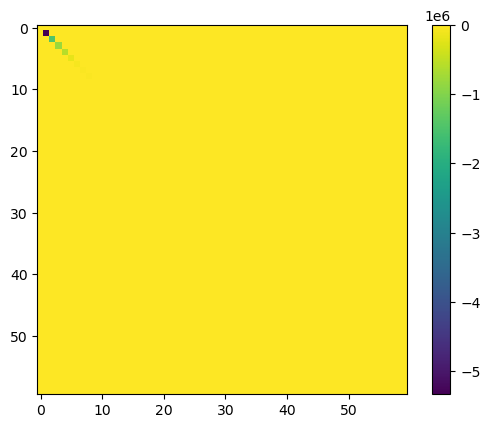

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6e0d90eb90>

In [62]:
imshow(variables.Σ_R[1,:,:])
colorbar()

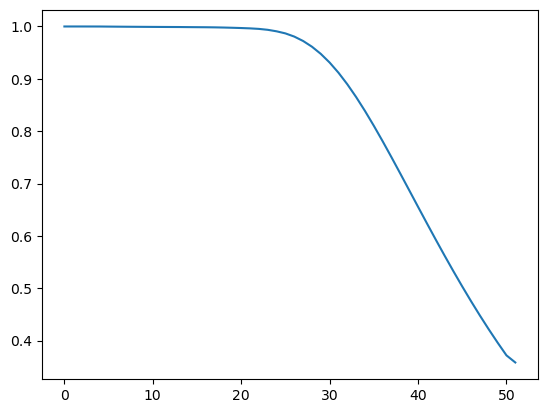

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdc93534810>

In [61]:
plot(diag(variables2.R[1,:,:]))

In [80]:
imshow(variables2.Σ_R[1,:,:] .- variables.Σ_R[1,:,:])
colorbar()

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 60 and 101

In [90]:
tmax = 0.5;
atol = 1e-5;
rtol = 1e-3;
tstart = 0.;
structure = Reaction_structure(rs_aaa);
variables = Reaction_variables(structure,"single");

sol = solve_dynamics(structure,variables,atol,rtol,tmax,tstart);

t: 0.0
2 1 0.0
2 2 -5.333328e6
2 1 0.0
2 2 -5.333328e6
t: 1.0e-6
3 1 0.0
3 2 5.33311852045333
3 3 -1.476915035909552e6
3 1 0.0
3 2 5.333118523581125
3 3 -1.476915035909552e6
t: 5.999999999999999e-6
4 1 0.0
4 2 5.332502681643085
4 3 5.332432918282247
4 4 -794449.0155484336
4 1 0.0
4 2 5.332502663819871
4 3 5.332773253263833
4 4 -794449.0155484336
t: 1.660690625086817e-5
5 1 0.0
5 2 5.331869988100057
5 3 5.3320661874089295
5 4 5.332379252348965
5 5 -567430.2281670448
5 1 0.0
5 2 5.331869988618141
5 3 5.332066173245946
5 4 5.33264735826187
5 5 -567430.2281670448
t: 2.9971531733456563e-5
6 1 0.0
6 2 5.329742790483262
6 3 5.330223446745033
6 4 5.330012453002405
6 5 5.328704787101251
6 6 -203177.12206466316
6 1 0.0
6 2 5.329742448604093
6 3 5.330223113667674
6 4 5.330012064042133
6 5 5.330700534534191
6 6 -203177.12206466316
t: 7.273347982236837e-5
7 1 0.0
7 2 5.324847135447998
7 3 5.325327463067736
7 4 5.325116403497207
7 5 5.325523982003591
7 6 5.328827076824204
7 7 -70569.36810391887
7 1 

19 1 0.0
19 2 4.2160710161262145
19 3 4.216471785999188
19 4 4.216263953320445
19 5 4.2177859306631555
19 6 4.217936351510381
19 7 4.2229935786721695
19 8 4.228416277428497
19 9 4.240873270346576
19 10 4.260093753318253
19 11 4.289061183569713
19 12 4.332149121374233
19 13 4.387276873565481
19 14 4.464915516714561
19 15 4.555923126764478
19 16 4.677940330392041
19 17 4.810387611270106
19 18 5.002023376789743
19 19 -1286.8959803450546
t: 0.02563952487888451
20 1 0.0
20 2 4.014838579259049
20 3 4.015224209053585
20 4 4.015018359980804
20 5 4.016480207236909
20 6 4.016582664800905
20 7 4.021434422404586
20 8 4.026507359319924
20 9 4.038400584152884
20 10 4.0565105434001705
20 11 4.084068457121221
20 12 4.124735960992308
20 13 4.1770783870798915
20 14 4.250387548842833
20 15 4.336684906375255
20 16 4.451887989936595
20 17 4.580761635803637
20 18 4.746992704889742
20 19 4.831624511028088
20 20 -1269.415553796118
20 1 0.0
20 2 4.013641842652721
20 3 4.0140273675357125
20 4 4.0138215598529845

28 1 0.0
28 2 2.3802108457867277
28 3 2.3804632305567006
28 4 2.3802939106938235
28 5 2.3812351238093976
28 6 2.381052891306724
28 7 2.3841432055407625
28 8 2.3866089655134615
28 9 2.3938433760768003
28 10 2.403429610074943
28 11 2.4196072212450592
28 12 2.441551370628793
28 13 2.471666277944382
28 14 2.511420068533548
28 15 2.5604060976203726
28 16 2.6228333169202642
28 17 2.69521014621777
28 18 2.784890838627694
28 19 2.8851769775228693
28 20 3.0071011963333327
28 21 3.140503869019023
28 22 3.300908648399045
28 23 3.474106249575083
28 24 3.6813694019746457
28 25 3.9033734442125607
28 26 4.169260286624217
28 27 4.317372992531832
28 28 -682.5298223643433
28 1 0.0
28 2 2.3782675119007433
28 3 2.378519712325054
28 4 2.3783504874979706
28 5 2.3792910002842937
28 6 2.3791086945410482
28 7 2.3821966811939768
28 8 2.3846599329531193
28 9 2.3918886046581234
28 10 2.4014659606648947
28 11 2.4176302170600676
28 12 2.4395544696440217
28 13 2.469643950505835
28 14 2.5093618886989493
28 15 2.55830

34 1 0.0
34 2 1.5019079575387568
34 3 1.5020790068977938
34 4 1.5019486972496563
34 5 1.502579605618004
34 6 1.5023440130408994
34 7 1.5044001733232655
34 8 1.5056871754036476
34 9 1.5103431117914354
34 10 1.5158212578780823
34 11 1.5259498605452388
34 12 1.5387231242299761
34 13 1.5572718412548392
34 14 1.5805226459168933
34 15 1.6103587800841725
34 16 1.6468574173847288
34 17 1.6905485762267576
34 18 1.7428207857548235
34 19 1.802868566143486
34 20 1.8735866577949167
34 21 1.952814196848487
34 22 2.0452579785954224
34 23 2.147236280307679
34 24 2.2657637924664624
34 25 2.3952490455512394
34 26 2.5481589966946543
34 27 2.704161954294388
34 28 2.890391053294564
34 29 3.0894563743275203
34 30 3.3122119238973187
34 31 3.559293521193558
34 32 3.829493288024021
34 33 4.013183891340075
34 34 -563.4235316393176
34 1 0.0
34 2 1.5005272143457895
34 3 1.5006981205922592
34 4 1.500567902611599
34 5 1.501198275324065
34 6 1.5009627547838726
34 7 1.503017152064634
34 8 1.5043026486977633
34 9 1.50

39 1 0.0
39 2 1.0036967503843606
39 3 1.0038171908374958
39 4 1.0037179074319544
39 5 1.004158767537418
39 6 1.003938632467101
39 7 1.0053679154590047
39 8 1.006088227266046
39 9 1.0092470137863825
39 10 1.0126113561499355
39 11 1.0193388488873167
39 12 1.0273175754988857
39 13 1.0394779419786522
39 14 1.0540653919380292
39 15 1.0734484005966887
39 16 1.0963444032917073
39 17 1.1245218015571792
39 18 1.1572327148980737
39 19 1.1957019992420852
39 20 1.2397802169532648
39 21 1.2902010697374702
39 22 1.3475217175920675
39 23 1.4119694601736157
39 24 1.4850023531156042
39 25 1.5662172024497876
39 26 1.6598401385060604
39 27 1.7563687437975344
39 28 1.8700844910213592
39 29 1.9913447245748288
39 30 2.1265245084257396
39 31 2.2757358433454136
39 32 2.440035023735818
39 33 2.6224032862313504
39 34 2.8249526703331513
39 35 3.0504034234772757
39 36 3.302088887406571
39 37 3.5804732762210842
39 38 3.772749534943877
39 39 -478.57800682428933
39 1 0.0
39 2 1.00260529228473
39 3 1.0027256116318397

44 1 0.0
44 2 0.6594073882113461
44 3 0.6594902017197122
44 4 0.6594176390097212
44 5 0.6597188408652748
44 6 0.6595365206448238
44 7 0.6605087115448486
44 8 0.6608979045704754
44 9 0.6630016018458067
44 10 0.6650336063532747
44 11 0.6694286315929295
44 12 0.6743356214609637
44 13 0.6821834177623272
44 14 0.6911967490762438
44 15 0.7035978696844079
44 16 0.7177450620586345
44 17 0.7356472386451973
44 18 0.7558125937635494
44 19 0.7800984940044602
44 20 0.807168404146152
44 21 0.8387984602657854
44 22 0.87382599752205
44 23 0.9139876405788204
44 24 0.9583482385819787
44 25 1.0085964767490552
44 26 1.0651241764605892
44 27 1.1240641318938216
44 28 1.1925801230521078
44 29 1.2654876772390722
44 30 1.3464785589108792
44 31 1.435439602334733
44 32 1.5329314751109775
44 33 1.6406204619572566
44 34 1.7596040739882586
44 35 1.8913286750446012
44 36 2.037593292777155
44 37 2.2003471384392292
44 38 2.3818937525999466
44 39 2.5849309904652125
44 40 2.8125892788080535
44 41 3.0684781957590905
44 4

48 1 0.0
48 2 0.46568339807788517
48 3 0.4657437624109497
48 4 0.46568877640001327
48 5 0.46590738830346756
48 6 0.46575940620488676
48 7 0.4664629038607469
48 8 0.46669490095656196
48 9 0.4681950661176202
48 10 0.4695391855839884
48 11 0.472630380004984
48 12 0.47592511321916314
48 13 0.4813953765624264
48 14 0.48747040295329197
48 15 0.49605886445191916
48 16 0.5055951019831532
48 17 0.5179285255013611
48 18 0.5314983387509549
48 19 0.5481499912478645
48 20 0.5663141120127275
48 21 0.5878986738479863
48 22 0.6113143124535338
48 23 0.6385850949674565
48 24 0.6681051818225396
48 25 0.7020426168013709
48 26 0.7394920256618434
48 27 0.7789010636486827
48 28 0.8242363504297585
48 29 0.8724071880708093
48 30 0.925779993001141
48 31 0.9841888458772761
48 32 1.0479704532967236
48 33 1.1181665699015526
48 34 1.1954208413078773
48 35 1.2806012772086364
48 36 1.3747844364667876
48 37 1.4791215772767434
48 38 1.5949691689139434
48 39 1.7239058542386798
48 40 1.8677499594367568
48 41 2.0286239232

52 1 0.0
52 2 0.32555001499616865
52 3 0.32559339267005655
52 4 0.32555260875757835
52 5 0.3257091321900397
52 6 0.3255936341306657
52 7 0.32609603846872226
52 8 0.3262313685392973
52 9 0.32728919052278677
52 10 0.32817187853198176
52 11 0.3303249549360739
52 12 0.3325213607127884
52 13 0.33630046486265736
52 14 0.3403657378469797
52 15 0.34626385648860575
52 16 0.35264637099314206
52 17 0.3610753798245516
52 18 0.37014337925905133
52 19 0.3814734004479636
52 20 0.3935793959509779
52 21 0.4082016171779778
52 22 0.42375318155610775
52 23 0.44214299931867224
52 24 0.46166591663209944
52 25 0.48443852016358435
52 26 0.5091038751824035
52 27 0.5352992290786166
52 28 0.5651319840813935
52 29 0.5967911070022056
52 30 0.6317859978762801
52 31 0.6699510916438781
52 32 0.7114886623957767
52 33 0.7570488953009815
52 34 0.8070069390180188
52 35 0.8618826778718054
52 36 0.9223190650427066
52 37 0.9889944525084198
52 38 1.0627061877580868
52 39 1.1443765198465226
52 40 1.2350601957530518
52 41 1.33

56 1 0.0
56 2 0.22529960816299927
56 3 0.22533034691955628
56 4 0.22530069167039263
56 5 0.22541127029232066
56 6 0.22532398840883733
56 7 0.22567815087646237
56 8 0.22575542182083264
56 9 0.2264930397768266
56 10 0.22706916158503837
56 11 0.22855438771368486
56 12 0.2300092493698066
56 13 0.23259714991163133
56 14 0.23529986114470003
56 15 0.2393172184730225
56 16 0.24356142766570732
56 17 0.24927745224829312
56 18 0.25529898226686576
56 19 0.262951535886927
56 20 0.27097101798812767
56 21 0.2808080413448658
56 22 0.29107715050100225
56 23 0.3033975801913158
56 24 0.3162391873652755
56 25 0.33142784461812946
56 26 0.3475917563950714
56 27 0.3649119312386906
56 28 0.3844509464273177
56 29 0.40516443979555866
56 30 0.428011736079752
56 31 0.4528502489121405
56 32 0.47980181817509027
56 33 0.509272120312808
56 34 0.5414789913448259
56 35 0.5767338702234973
56 36 0.6154208271333826
56 37 0.6579395515767252
56 38 0.7047589874542137
56 39 0.7564183154585638
56 40 0.8135299376057428
56 41 0.

59 1 0.0
59 2 0.16980812541681395
59 3 0.1698316524507365
59 4 0.16980858646662056
59 5 0.16989305655347098
59 6 0.16982359884288561
59 7 0.17009376375251173
59 8 0.17014381428460895
59 9 0.17070252635835292
59 10 0.17111938441581076
59 11 0.172236385825284
59 12 0.17330035339016892
59 13 0.1752371393019408
59 14 0.17721890827905168
59 15 0.18021461393274835
59 16 0.18332726923964976
59 17 0.187576967880908
59 18 0.19198891336347046
59 19 0.19766290559293315
59 20 0.20352907512292445
59 21 0.21080313147443125
59 22 0.2182985196985488
59 23 0.2273833901825189
59 24 0.23673163522333013
59 25 0.2478976519232075
59 26 0.25963481117569776
59 27 0.27229201858461755
59 28 0.2864762996515339
59 29 0.30150324674577267
59 30 0.31805450339534863
59 31 0.33600945613843247
59 32 0.35545163773128197
59 33 0.37666593472706134
59 34 0.39979708783538576
59 35 0.42505740763288935
59 36 0.45270816529257285
59 37 0.4830184661803058
59 38 0.5163037247266496
59 39 0.552925038372444
59 40 0.5932904940862865


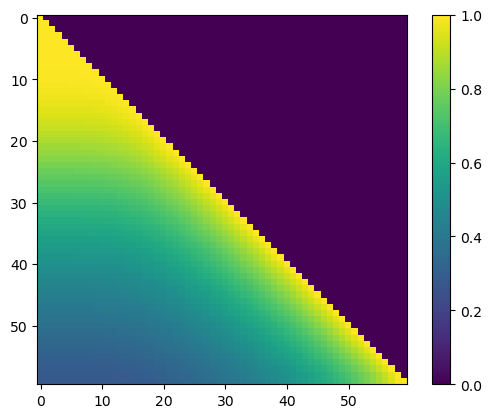

PyObject <matplotlib.colorbar.Colorbar object at 0x7fdc92c4de10>

In [91]:
imshow(variables.R[1,:,:])
colorbar()

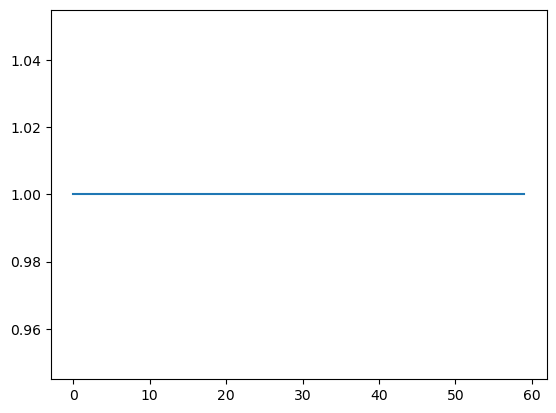

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdc92cda990>

In [92]:
plot(diag(variables.R[1,:,:]))

In [53]:
temp = deepcopy(variables.Σ_R[1,:,:])
for i in 1:length(sol.t)
    temp[i,i] = 0 
end

In [54]:
length(sol.t)

123

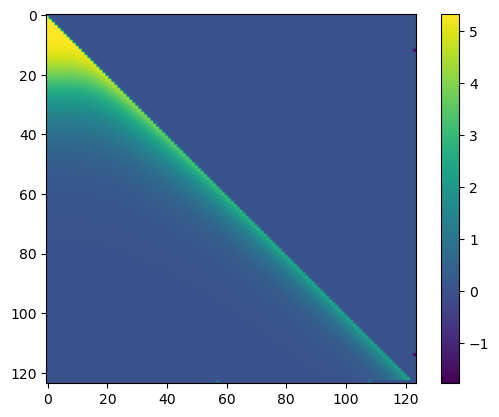

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6e0dc88850>

In [55]:
imshow(temp)
colorbar()

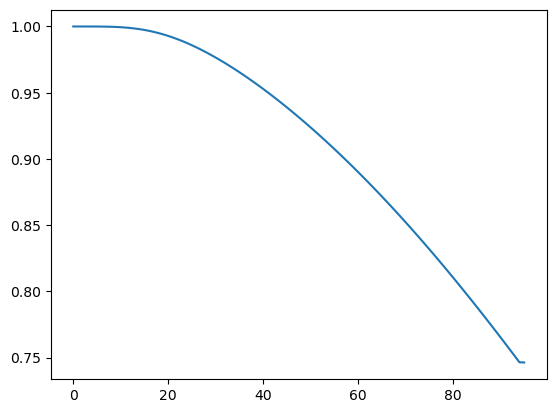

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6e0d488550>

In [88]:
plot(diag(variables.R[1,:,:]))

In [64]:
plot_all_moddiag(variables,sol)

LoadError: BoundsError: attempt to access 1×60 GreenFunction{Float64, 2, Matrix{Float64}, OnePoint} at index [2, 1:60]

In [1150]:
tmax = 10.;
atol = 1e-4;
rtol = 1e-2;
tstart = 0.;
structure2 = Reaction_structure(rs_abc);
variables2 = Reaction_variables(structure2,"single");

sol2 = solve_dynamics(structure2,variables2,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 2.532045508417225e-5
t: 5.508422162037684e-5
t: 0.00016025729951674682
t: 0.0004938124770029854
t: 0.001297561976126453
t: 0.0026171811527518495
t: 0.005499771294090832
t: 0.0098383766356701
t: 0.017261594375490477
t: 0.027262887251770788
t: 0.04195166234806765
t: 0.06021026975813167
t: 0.08425914431182088
t: 0.11062138012885131
t: 0.14092631115364007
t: 0.17550703618122723
t: 0.21356665355025714
t: 0.2553648473515842
t: 0.30081729274924573
t: 0.34963631268907824
t: 0.40172492085877415
t: 0.4569108211212705
t: 0.5149894026484976
t: 0.5757930265726747
t: 0.6391461324574965
t: 0.7048759093428751
t: 0.7728247839762449
t: 0.8428434492650806
t: 0.9147930026645146
t: 0.9885468674797074
t: 1.0639892993440019
t: 1.14101523122652
t: 1.2195299622752096
t: 1.2994482341350202
t: 1.3806935037933616
t: 1.4631972017097647
t: 1.5468979216298524
t: 1.6317406845536215
t: 1.717676249464846
t: 1.8046604637634551
t: 1.892653676189224
t: 1.9816202065806405
t: 2.07

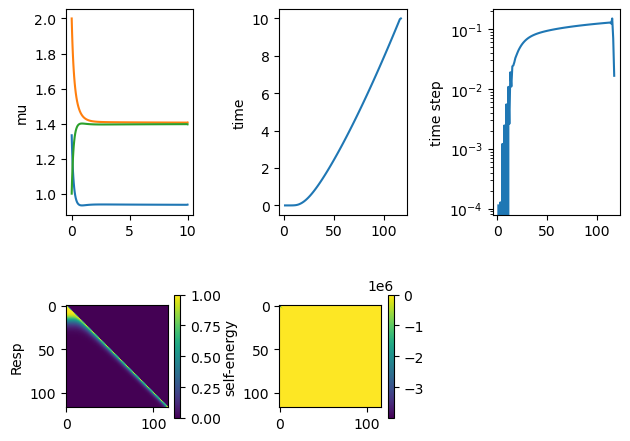

In [1151]:
plot_all(variables2,sol2)

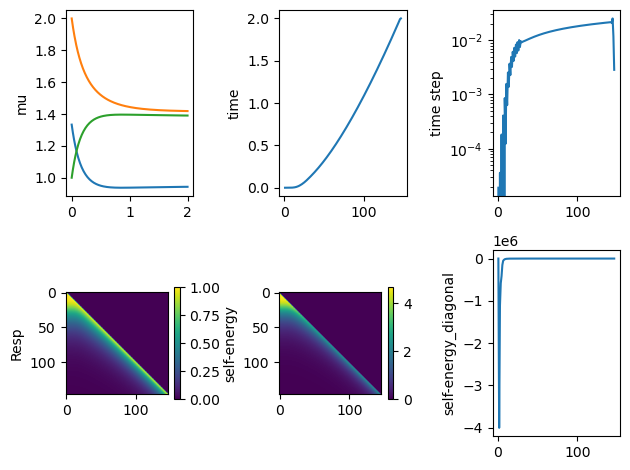

In [1223]:
plot_all_moddiag(variables,sol)

In [1225]:
variables_mak = Reaction_variables(structure,"single");
sol_mak = solve_dynamics(structure,variables_mak,atol,rtol,tmax,tstart);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.6864691236121283e-5
t: 3.064257660600729e-5
t: 7.338087861532837e-5
t: 0.00017161814687299457
t: 0.0003717859324905891
t: 0.0006758345268118875
t: 0.001230016524624063
t: 0.002000404930284855
t: 0.0031774236054850653
t: 0.004679564912176038
t: 0.006723209799125898
t: 0.009173589926037371
t: 0.012243476376844824
t: 0.015759674403559253
t: 0.019914778882476825
t: 0.024518112137814685
t: 0.029736559408853308
t: 0.035380188640542806
t: 0.041591351969600794
t: 0.04819241391809756
t: 0.0553052027166895
t: 0.06276949098089751
t: 0.07069116403696755
t: 0.0789280256839534
t: 0.08757416006872701
t: 0.09650356178131862
t: 0.10580189831432331
t: 0.11504509307692466
t: 0.12446235587309863
t: 0.13404550896312323
t: 0.14375167211435613
t: 0.15361587497735968
t: 0.16363619598939322
t: 0.1738102259523015
t: 0.18414402131361196
t: 0.19463788426572226
t: 0.20529226989247448
t: 0.21610821585331166
t: 0.22708569911614968
t: 0.23822455317329325
t: 0.249524454848

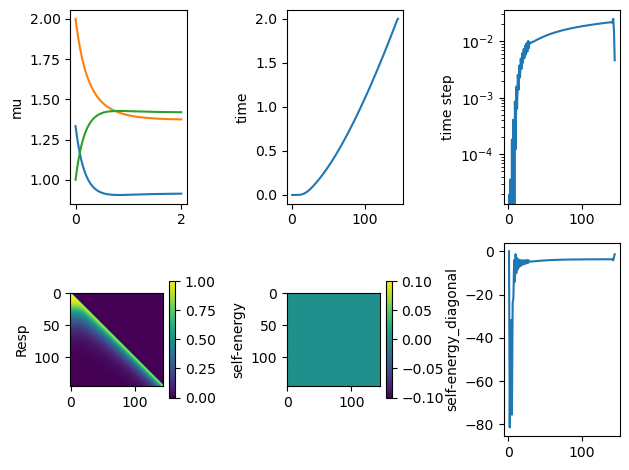

In [1228]:
plot_all_moddiag(variables_mak,sol_mak)

## TODO: Compare to old SBR method with $\Sigma_\mu = \Sigma_R$

In [12]:
function plot_all_moddiag(rxn_variables,solution)
    
    #Plots the diagonal values separately for the self-energy
    #This equalizes the scale difference so that the values are better visible
    
    subplot(231)
    PyPlot.plot(solution.t, rxn_variables.μ[1,:])
    PyPlot.plot(solution.t, rxn_variables.μ[2,:])
    PyPlot.plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    PyPlot.plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    PyPlot.plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")
    yscale("log")

    subplot(234)
    imshow(rxn_variables.R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("Resp")
    
    temp = deepcopy(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)])
    
    for i in 1:length(solution.t)
        #temp[i,i] *= solution.w[length(solution.t)][i]
         temp[i,i] = 0
    end
    
    subplot(235)
    imshow(temp)
    colorbar(shrink=0.6)
    ylabel("self-energy")
    
    subplot(236)
    PyPlot.plot(1:length(solution.t),diag(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)].*abs.(solution.w[length(solution.t)])))
    #PyPlot.plot(1:length(solution.t),diag(rxn_variables.Σ_R[1,1:length(solution.t),1:length(solution.t)]))

    ylabel("self-energy_diagonal")
    
    tight_layout()
    
end

plot_all_moddiag (generic function with 1 method)

In [1114]:
function plot_all(rxn_variables,solution)
    
    #TODO: Write a function to plot the diagonal separately from the 
    
    subplot(231)
    PyPlot.plot(solution.t, rxn_variables.μ[1,:])
    PyPlot.plot(solution.t, rxn_variables.μ[2,:])
    PyPlot.plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    PyPlot.plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    PyPlot.plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")
    yscale("log")

    subplot(234)
    imshow(rxn_variables.R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("Resp")

    subplot(235)
    imshow(rxn_variables.Σ_R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("self-energy")
    
    tight_layout()
    
end

plot_all (generic function with 1 method)

In [15]:
function c_mn_no_mu(structure,int_rxn_index,m,n)
    #"""
    #Creates the c_mn for each individual beta reaction (without the \mu factors)
    #"""
    
    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        c_mnBeta = 0.

    else
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        ))*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n))
    
    end
    
    return c_mnBeta
end

function c_mn(structure,variables,int_rxn_index,m,n,time)
    #"""
    #Creates the c_mn for each individual beta reaction (including the \mu factors)
    #"""

    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        
        c_mnBeta = 0.

    else
        if time>1
        
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        )).*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n)).*prod(variables.μ[:,time-1] .^(structure.stochiometry_react[:,int_rxn_index].-n))
        
        #Note that this cmn is defined with the time shift t- in \mu! ## PAY ATTENTION!
        else
            c_mnBeta = 0.
        end
        
    end
        
    return c_mnBeta
    
end

function c_mnFULL(structure,variables,m,n,time)

    retval = 0.
    
    for k in 1:structure.num_interactions
        retval += c_mn(structure,variables,k,m,n,time)
    end
    
    return retval
    
end

function c_mnFULL_test(structure,variables,m,n)
    
    #This function tests if a partciular cmn_full (no_mu) is zero or not.
    
    retval = 0.
    
    #TODO this thing
    
    for k in 1:structure.num_interactions
        retval += c_mn_no_mu(structure,k,m,n)
    end
    
    return retval
    
end

function create_c_mn_dict(structure,variables,m_list,n_list)
    #"""
    #Creates a dictionary for the c_mn for each individual beta reaction (without the \mu factors) where the output is a dictionary and can be looked up by [int(rxn_index),tuple(m),tuple(n)]
    #"""

    c_mn_dict = Dict()

    for int_rxn_index in range(1,structure.num_interactions)
        
        #Note that for the m_list, n_list above, they should be the m-list, n-list 
        #corresponding to each reaction individually 
        for m in m_list[int_rxn_index]
            for n in n_list[int_rxn_index]
                
                #Can already NOT SAVE many of the c_mn which are zero at this point!
                
                c_mn_dict[(int_rxn_index,m,n)] = c_mn_no_mu(structure,int_rxn_index,m,n)
                #c_mn_dict[(int_rxn_index,tuple(m),tuple(n))] = c_mn_no_mu(structure,int_rxn_index,m,n)
            
            end
        end
    end
    
    return c_mn_dict

end             

create_c_mn_dict (generic function with 1 method)

function c_mn_no_mu(structure,int_rxn_index,m,n)
    #"""
    #Creates the c_mn for each individual beta reaction (without the \mu factors)
    #"""
    
    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        c_mnBeta = 0.

    else
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        ))*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n))
    
    end
    
    return c_mnBeta
end

function c_mn(structure,variables,int_rxn_index,m,n,time)
    #"""
    #Creates the c_mn for each individual beta reaction (including the \mu factors)
    #"""

    if any(n.-structure.stochiometry_react[:,int_rxn_index] .> 0.)
        
        c_mnBeta = 0.

    else
        c_mnBeta = structure.rate_interaction[int_rxn_index]*(prod(
        binomial.(structure.stochiometry_prod[:,int_rxn_index],m).*(1 .^(structure.stochiometry_prod[:,int_rxn_index].-m))
        ) .- prod(binomial.(structure.stochiometry_react[:,int_rxn_index],m).*(1 .^(structure.stochiometry_react[:,int_rxn_index].-m) )
        ))*prod(binomial.(structure.stochiometry_react[:,int_rxn_index],n))*prod(variables.μ[:,time] .^(structure.stochiometry_react[:,int_rxn_index].-n))
    
    end
        
    return c_mnBeta
    
end

function c_mnFULL(structure,variables,m,n,time)

    retval = 0.
    
    for k in 1:structure.num_interactions
        retval += c_mn(structure,variables,k,m,n,time)
    end
    
    return retval
    
end

function c_mnFULL_test(structure,variables,m,n)
    
    #This function tests if a partciular cmn_full (no_mu) is zero or not.
    
    retval = 0.
    
    #TODO this thing
    
    for k in 1:structure.num_interactions
        #retval += c_mn_no_mu(structure,variables,k,m,n)
        retval += c_mn_no_mu(structure,k,m,n)
    end
    
    return retval
    
end

function create_c_mn_dict(structure,variables,m_list,n_list)
    #"""
    #Creates a dictionary for the c_mn for each individual beta reaction (without the \mu factors) where the output is a dictionary and can be looked up by [int(rxn_index),tuple(m),tuple(n)]
    #"""

    c_mn_dict = Dict()

    for int_rxn_index in range(1,structure.num_interactions)
        
        #Note that for the m_list, n_list above, they should be the m-list, n-list 
        #corresponding to each reaction individually 
        for m in m_list[int_rxn_index]
            for n in n_list[int_rxn_index]
                
                #Can already NOT SAVE many of the c_mn which are zero at this point!
                
                c_mn_dict[(int_rxn_index,m,n)] = c_mn_no_mu(structure,int_rxn_index,m,n)
                #c_mn_dict[(int_rxn_index,tuple(m),tuple(n))] = c_mn_no_mu(structure,int_rxn_index,m,n)
            
            end
        end
    end
    
    return c_mn_dict

end             

In [964]:
[c_mnFULL(structure,variables,[1,1,1],[1,0,1],time) for time in 1:10]

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [266]:
(create_c_mn_dict(structure,variables,m_list,n_list))

Dict{Any, Any} with 48 entries:
  (1, (1, 0, 1), (0, 1, 0)) => 0.0
  (1, (1, 0, 0), (1, 0, 0)) => -1.0
  (1, (1, 1, 1), (0, 0, 0)) => 0.0
  (2, (1, 0, 0), (0, 0, 0)) => 1.2
  (2, (1, 0, 1), (0, 0, 1)) => 0.0
  (1, (0, 1, 0), (1, 1, 0)) => -1.0
  (1, (0, 0, 0), (0, 0, 0)) => 0.0
  (1, (1, 0, 0), (1, 1, 0)) => -1.0
  (1, (1, 1, 1), (0, 1, 0)) => 0.0
  (1, (1, 1, 0), (1, 0, 0)) => -1.0
  (1, (0, 0, 1), (1, 0, 0)) => 1.0
  (2, (1, 1, 0), (0, 0, 0)) => 1.2
  (2, (0, 0, 1), (0, 0, 0)) => -1.2
  (2, (1, 1, 1), (0, 0, 1)) => 0.0
  (1, (0, 0, 0), (0, 1, 0)) => 0.0
  (1, (0, 1, 0), (0, 0, 0)) => -1.0
  (2, (0, 0, 0), (0, 0, 1)) => 0.0
  (1, (1, 1, 0), (1, 1, 0)) => -1.0
  (1, (0, 0, 1), (1, 1, 0)) => 1.0
  (1, (0, 1, 1), (1, 0, 0)) => 0.0
  (1, (1, 0, 0), (0, 0, 0)) => -1.0
  (2, (0, 1, 1), (0, 0, 0)) => 0.0
  (1, (0, 1, 0), (0, 1, 0)) => -1.0
  (1, (1, 0, 1), (1, 0, 0)) => 0.0
  (2, (0, 1, 0), (0, 0, 1)) => 1.2
  ⋮                         => ⋮

In [16]:
function mnList(structure)
    
    num_int = structure.num_interactions
    num_species = structure.num_species
    s_i = structure.stochiometry_prod
    r_i = structure.stochiometry_react
    
    m_list = []
    n_list = []
    m_listFULL = []
    n_listFULL = []
    
    for i in 1:num_int
        
        x = vec(collect(product([0:Int(max(s_i[j,i], r_i[j,i])) for j in 1:num_species]...)))
        y = vec(collect(product([0:Int(r_i[j,i]) for j in 1:num_species]...)))
        
        #The above creates tuples(Int, Int ... , Int (len = num_species)) which needs to be converted to an array,
        # Otherwise it runs into issues later!
        
        x′ = []
        y′ = []      
        
        push!(x′,[[Int(j) for j in k] for k in x])
        push!(y′,[[Int(j) for j in k] for k in y])
        
        push!(m_list, x′[1])
        push!(n_list, y′[1])
    end
    
    #Construct the full lists here
    max1 = zeros(Int,num_species)
    max2 = zeros(Int,num_species)
    
    for j in 1:num_species
    
        max1[j] = maximum(cat(collect(s_i[j,i] for i in 1:num_int),collect(r_i[j,i] for i in 1:num_int),dims=1))
        max2[j] = maximum(collect(r_i[j,i] for i in 1:num_int))
    end
    
    
    a = vec(collect(product([0:max1[j] for j in 1:num_species]...)))
    b = vec(collect(product([0:max2[j] for j in 1:num_species]...)))

    push!(m_listFULL, a)
    push!(n_listFULL, b)
    
    #Also define the NEW lists which are just the intersection of the lists across the different reactions,
    #the FULL lists are overkills and have extra elements
    
    m_listNEW = union(collect.(m_list[j] for j in 1:num_int)...)
    n_listNEW = union(collect.(n_list[j] for j in 1:num_int)...)
    
    #create excluded lists as well:

    return m_list, n_list, m_listFULL, n_listFULL, m_listNEW, n_listNEW
    
end


m_list, n_list, m_listFULL, n_listFULL, m_listNEW, n_listNEW = mnList(structure)


(Any[[[0], [1], [2]]], Any[[[0], [1], [2]]], Any[[(0,), (1,), (2,)]], Any[[(0,), (1,), (2,)]], [[0], [1], [2]], [[0], [1], [2]])

## Saving:

In [173]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_1.csv", "w")
mn = convert(Array,mu_SBR[:])
    
writedlm(abc, vcat(transpose(sol_SBR.t),transpose(mn))) 
close(abc)

In [174]:
#touch("data/momentClosure/MM1_KM_scaleSubstrate_2/alpha_"*string(i)*".csv")
using DelimitedFiles

touch("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv")

abc = open("/home/harsh/Work/code/KadanoffBaym.jl/data/AA_A_2.csv", "w")
mn = convert(Array,mu_SBR2[:])
    
writedlm(abc, vcat(transpose(sol_SBR2.t),transpose(mn))) 
close(abc)

## Define a structure to hold the $R, \mu, \Sigma$ etc

In [13]:
# Setting up the reactions and the parameters:

num_species     = 3 #Number of species in the reaction system
num_interaction = 1 # Number of interating reactions in the Hamiltonian
num_reactions   = 2*num_species + num_interaction # This counts the total number of possible reactions in the system.
                                        # We have 2N creation and destruction reactions and the rest interaction reactions
# k1,A = 8, k2,A = 3, k1,B =8, k2,B =2, k1,C =3, k2,C =1.5 and k3 =0.5.

# Rate constants for the reaction system: [k1 is Creation and k2 is Destruction]
k1 = [4,4,3] #len must be equal to num_species
k2 = [3,2,3] #len must be equal to num_species

k3 = [1.]

initial_values = k1./k2

s_i = [1]
r_i = [2]


1-element Vector{Int64}:
 2

In [40]:
Base.@kwdef struct reaction_structure_def{T1,T2,T3,T4}
    
    num_species::T1
    num_interactions::T1
    num_reactions::T1 = 2*num_species + num_interactions
    
    k1::T2
    k2::T2
    k3::T4
    
    s_i::T3
    r_i::T3
    
    initial_values::T4
    
end

In [80]:
ABC = reaction_structure_def(num_species=num_species,num_interactions=num_interaction,
    k1=k1,k2=k2,k3=k3,s_i=s_i,r_i=r_i,initial_values=initial_values);

In [110]:
Base.@kwdef struct reaction_variables_def{T1,T2,T3}
    
    reaction_structure::T1
    
    R::T2   = GreenFunction(zeros(Float64,reaction_structure.num_species,1,1), Response)
    μ::T3   = GreenFunction(zeros(Float64,reaction_structure.num_species,1), OnePoint)
    Σ_R::T2 = zero(R)
    Σ_μ::T2 = zero(R)
    
end

ABC_variables = reaction_variables_def(reaction_structure=ABC);

In [111]:
function initialize_reactions(rxn_structure::reaction_structure_def,rxn_variables::reaction_variables_def)
    rxn_variables.R[:,1,1] = ones(rxn_structure.num_species)
    rxn_variables.μ[:,1]   = rxn_structure.initial_values
    
end

initialize_reactions (generic function with 1 method)

In [112]:
initialize_reactions(ABC,ABC_variables);

3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [121]:
# Right-hand side for the "vertical" evolution
function fv!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def,
        out, times, h1, h2, t, t′)
    
    temp    = zero(rxn_variables.R[t,t′])
    corr    = integrate2(h1, t, t′, rxn_variables.Σ_R, rxn_variables.R, rxn_variables.μ)
    
    temp[1] = -rxn_structure.k2[1]*rxn_variables.R[1,t,t′] -rxn_structure.k3[1]*rxn_variables.μ[2,t]*rxn_variables.R[1,t,t′]
    temp[2] = -rxn_structure.k2[2]*rxn_variables.R[2,t,t′] -rxn_structure.k3[1]*rxn_variables.μ[1,t]*rxn_variables.R[2,t,t′]
    temp[3] = -rxn_structure.k2[3]*rxn_variables.R[3,t,t′]
    
    out[1]  = temp .+ rxn_structure.k3[1]^2 .*corr
    
end

#diagonal evolution
function fd!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def, out, times, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# one-time equation for condensate amplitude
function f1!(rxn_variables::reaction_variables_def, rxn_structure::reaction_structure_def, out, times, h1, t)
    
    temp    = zero(rxn_variables.μ[t])
    corr    = integrate1(h1, t, rxn_variables.Σ_μ, rxn_variables.μ)
    
    temp[1] = rxn_structure.k1[1] .- rxn_structure.k2[1].*rxn_variables.μ[1,t] .-rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    temp[2] = rxn_structure.k1[2] .- rxn_structure.k2[2].*rxn_variables.μ[2,t] .-rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    temp[3] = rxn_structure.k1[3] .- rxn_structure.k2[3].*rxn_variables.μ[3,t] .+rxn_structure.k3[1].*rxn_variables.μ[1,t].*rxn_variables.μ[2,t]
    
    out[1]  = temp .+ rxn_structure.k3[1]^2 .*corr
    
end

f1! (generic function with 2 methods)

In [122]:
function integrate1(hs::Vector, t1, Σ::GreenFunction, μ::GreenFunction; tmax=t1)
    retval = zero(μ[t1])
    
    for k in 1:tmax
        retval[1] +=  Σ[1,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[2] +=  Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        retval[3] += -Σ[2,t1,k]*μ[1,k]*μ[2,k]*hs[k]
        
    end
    return retval
end

function integrate2(hs::Vector, t1, t2, Σ::GreenFunction, R::GreenFunction, μ::GreenFunction; tmax=t1)
    
    retval = zero(R[t1,t2])

    for k in t2:t1
        retval[1] += Σ[1,t1,k].*μ[2,k]*R[1,k,t2]*hs[k]
        retval[2] += Σ[2,t1,k].*μ[1,k]*R[2,k,t2]*hs[k]        
    end
    
    return retval
end

integrate2 (generic function with 1 method)

In [127]:
# Callback function for the self-energies
function self_energy!(rxn_variables::reaction_variables_def,times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(rxn_variables.R, 2)) > size(rxn_variables.Σ_R, 2)
        resize!(rxn_variables.Σ_R, n)
        resize!(rxn_variables.Σ_μ, n)
    end
    
    rxn_variables.Σ_R[1,t,t′] = (rxn_variables.R[1,:,:].*rxn_variables.R[2,:,:])[t,t′]
    rxn_variables.Σ_R[2,t,t′] = (rxn_variables.R[1,:,:].*rxn_variables.R[2,:,:])[t,t′]
    
    rxn_variables.Σ_μ[:,t,t′] = rxn_variables.Σ_R[:,t,t′]
    
end

self_energy! (generic function with 1 method)

In [128]:
@time sol_try1 = kbsolve!(
    (x...) -> fv!(ABC_variables, ABC, x...),
    (x...) -> fd!(ABC_variables, ABC, x...),
    [ABC_variables.R],
    (0.0, tmax);
    callback = (x...) -> self_energy!(ABC_variables, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [ABC_variables.μ,],
    f1! = (x...) -> f1!(ABC_variables, ABC, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.2202400187937346e-5
t: 1.8576783521097632e-5
t: 3.56039820471803e-5
t: 6.44707955843092e-5
t: 0.00011420669163182947
t: 0.00018312994924129465
t: 0.0002888870267336592
t: 0.0004244745878852649
t: 0.0006096742161205569
t: 0.0008328283610359712
t: 0.0011138322979786968
t: 0.0014372867172953352
t: 0.0018215327303525877
t: 0.002249201110119255
t: 0.002736416074615619
t: 0.0032654803435381375
t: 0.003850279109155985
t: 0.004473922194753591
t: 0.005148338883204616
t: 0.005858041468957913
t: 0.006613377175654042
t: 0.007400447954626227
t: 0.00822837799201209
t: 0.009084796578676085
t: 0.009977909519671825
t: 0.010896687622814429
t: 0.011848661496303425
t: 0.012823915891688426
t: 0.01382949400310438
t: 0.014856370750870297
t: 0.015911244221189478
t: 0.016985780869199652
t: 0.018086440355350265
t: 0.01920541430842705
t: 0.02034900344370676
t: 0.02150979018519873
t: 0.0226939753152965
t: 0.023894426042986805
t: 0.02511728696064671
t: 0.02635562773580

t: 0.9482376624783333
t: 0.9519998476488141
t: 0.9557673096799096
t: 0.9595400402471477
t: 0.9633180310613959
t: 0.9671012738689242
t: 0.9708897604514267
t: 0.9746834826260099
t: 0.9784824322451505
t: 0.982286601196629
t: 0.9860959814034413
t: 0.9899105648236928
t: 0.9937303434504761
t: 0.9975553093117367
t: 1.0013854544701275
t: 1.0052207710228525
t: 1.009061251101505
t: 1.0129068868718978
t: 1.0167576705338885
t: 1.0206135943212002
t: 1.0244746505012388
t: 1.0283408313749067
t: 1.0322121292764155
t: 1.0360885365730956
t: 1.0399700456652055
t: 1.0438566489857388
t: 1.0477483390002327
t: 1.0516451082065734
t: 1.0555469491348042
t: 1.059453854346931
t: 1.0633658164367303
t: 1.0672828280295568
t: 1.0712048817821502
t: 1.0751319703824458
t: 1.0790640865493824
t: 1.0830012230327128
t: 1.086943372612816
t: 1.0908905281005077
t: 1.0948426823368547
t: 1.0987998281929883
t: 1.1027619585699195
t: 1.1067290663983558
t: 1.1107011446385175
t: 1.1146781862799573
t: 1.1186601843413793
t: 1.122647131

In [137]:
function plot_all(rxn_variables::reaction_variables_def,solution)
    
    subplot(231)
    plot(solution.t, rxn_variables.μ[1,:])
    plot(solution.t, rxn_variables.μ[2,:])
    plot(solution.t, rxn_variables.μ[3,:])
    ylabel("mu")

    subplot(232)
    plot(1:length(solution.t),solution.t)
    ylabel("time")

    subplot(233)
    plot(1:length(solution.t),solution.w[length(solution.t)])
    ylabel("time step")

    subplot(234)
    imshow(rxn_variables.R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("Resp")

    subplot(235)
    imshow(rxn_variables.Σ_R[1,:,:])
    colorbar(shrink=0.6)
    ylabel("self-energy")
    
    tight_layout()
    
end

plot_all (generic function with 1 method)

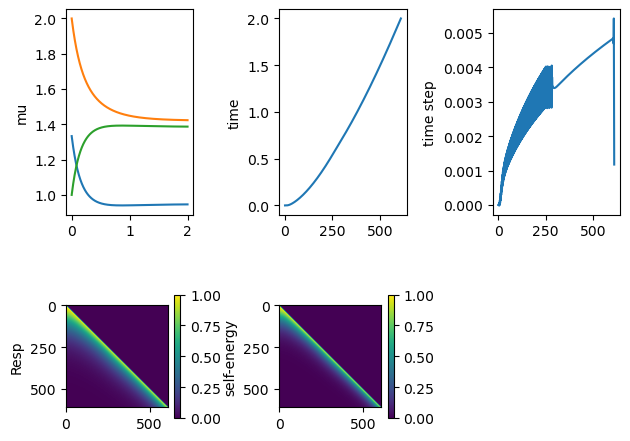

In [138]:
plot_all(ABC_variables,sol_try1)

In [143]:
# Callback function for the self-energies
function self_energy_SBR!(rxn_variables::reaction_variables_def,rxn_structure::reaction_structure_def,times, h1, h2 , t, t′)
        
    # Resize self-energies when Green functions are resized    
    if (n = size(rxn_variables.R, 2)) > size(rxn_variables.Σ_R, 2)
        resize!(rxn_variables.Σ_R, n)
        resize!(rxn_variables.Σ_μ, n)
    end
    
    id = one(rxn_variables.Σ_μ[1,1:t,1:t])
    
    #shifted1 = circshift(resp_gf[1,1:t,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    
    #Implement circshifts together later -- TODO
    
    shifted1  = rxn_variables.R[1,1:t,1:t].*rxn_variables.R[2,1:t,1:t]
    shifted2  = zeros(size(shifted1))
    shifted3  = zeros(size(shifted1))
    
    #print(size(mu))
    #print(size(resp_gf))
    
    for k in 1:t
        shifted2[k,1:t] = rxn_variables.μ[1,k].*rxn_variables.R[2,k,1:t].*h1
        shifted3[k,1:t] = rxn_variables.μ[2,k].*rxn_variables.R[1,k,1:t].*h1
        shifted1[k,1:t] .*= h1
    end
    
    #for k in 1:t
    #    shifted2 = circshift(mu[1,1:t].*resp_gf[2,1:t,1:t],(-1,0))
    #    shifted3 = circshift(mu[2,1:t].*resp_gf[1,1:t,1:t],(-1,0))
    #end
    
    #circshift()
    
    #for k in 1:t
        #shifted1[k,1:t] .*= h1
        #shifted2[k,1:t] .*= h1
    #end
    
    rxn_variables.Σ_μ[1,t,t′] = ((rxn_variables.R[1,1:t,1:t].*rxn_variables.R[2,1:t,1:t])*inv(tril(id + rxn_structure.k3[1].*shifted1[:,:])))[t,t′]
    rxn_variables.Σ_μ[2,t,t′] = rxn_variables.Σ_μ[1,t,t′]
    
    rxn_variables.Σ_R[1,t,t′] = ((shifted2[1:t,1:t]./h1)*inv(tril(id + rxn_structure.k3[1].*shifted2[:,:])))[t,t′]
    rxn_variables.Σ_R[2,t,t′] = ((shifted3[1:t,1:t]./h1)*inv(tril(id + rxn_structure.k3[1].*shifted3[:,:])))[t,t′]
    
end

self_energy_SBR! (generic function with 1 method)

In [145]:
ABC_variables_SBR = reaction_variables_def(reaction_structure=ABC);
initialize_reactions(ABC,ABC_variables_SBR)

3-element Vector{Float64}:
 1.3333333333333333
 2.0
 1.0

In [146]:
@time sol_try_SBR = kbsolve!(
    (x...) -> fv!(ABC_variables_SBR, ABC, x...),
    (x...) -> fd!(ABC_variables_SBR, ABC, x...),
    [ABC_variables_SBR.R],
    (0.0, tmax);
    callback = (x...) -> self_energy_SBR!(ABC_variables_SBR, ABC, x...),
    atol = 10*atol,
    rtol = 10*rtol,
    stop = x -> (println("t: $(x[end])"); flush(stdout); false),
    v0 = [ABC_variables_SBR.μ,],
    f1! = (x...) -> f1!(ABC_variables_SBR, ABC, x...)
);

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 1.7029594198676146e-5
t: 3.107745454372053e-5
t: 7.418013293108855e-5
t: 0.00017350102048607278
t: 0.000375156622138531
t: 0.0006810996686264835
t: 0.0012380699787453734
t: 0.00201185681477519
t: 0.0031928460932145403
t: 0.004699325943344774
t: 0.006747105819517196
t: 0.009201528007216452
t: 0.01227397158623661
t: 0.015792119369380946
t: 0.01994604692398957
t: 0.024547220951335758
t: 0.029758548008193896
t: 0.03539395034839715
t: 0.041590010019254074
t: 0.04817499446435483
t: 0.05526283867509456
t: 0.06270153858687863
t: 0.07058661548422612
t: 0.07878668915903543
t: 0.08738263153026578
t: 0.09596143328528532
t: 0.10473781470371904
t: 0.11370607465574928
t: 0.12281912584137172
t: 0.1321084588769918
t: 0.14157062530757672
t: 0.15120084066685655
t: 0.1610033233664248
t: 0.17097688470968614
t: 0.18112052256347833
t: 0.19143404746324755
t: 0.2019163586805471
t: 0.21256632028692124
t: 0.2233827630182512
t: 0.2343643049024154
t: 0.24550949303500194


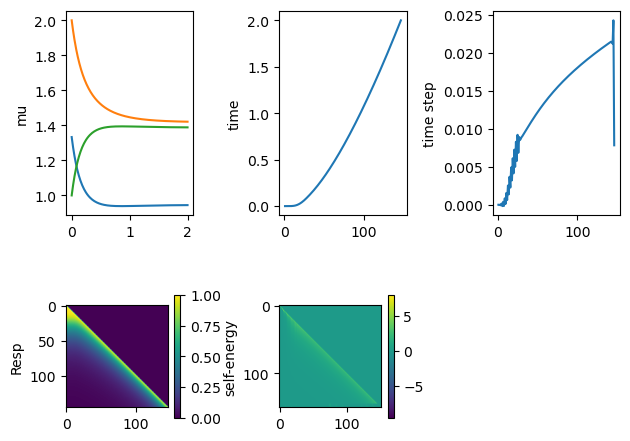

In [147]:
plot_all(ABC_variables_SBR,sol_try_SBR)

In [ ]:
pcolor()